<a href="https://colab.research.google.com/github/prem151105/Ask-Query/blob/main/p12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install torch torchvision matplotlib scikit-learn scikit-fuzzy pillow timm

In [37]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the directory paths
train_img_dir = '/content/drive/MyDrive/p1/DRIVE/training/images'
train_mask_dir = '/content/drive/MyDrive/p1/DRIVE/training/mask'
test_img_dir = '/content/drive/MyDrive/p1/DRIVE/test/images'
test_mask_dir = '/content/drive/MyDrive/p1/DRIVE/test/mask'

# Function to count files in a directory
def count_files(dir_path):
    if os.path.exists(dir_path):
        return len([f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])
    return 0

# Function to convert .gif to .png
def convert_gif_to_png(dir_path):
    for filename in os.listdir(dir_path):
        if filename.endswith('.gif'):
            gif_path = os.path.join(dir_path, filename)
            img = Image.open(gif_path).convert('L')  # Convert to grayscale (for masks)
            png_path = gif_path.replace('.gif', '.png')  # Replace the extension
            img.save(png_path, 'PNG')
            print(f"Converted {filename} to PNG")
            os.remove(gif_path)  # Optionally, remove the original gif

# Convert masks from .gif to .png for training and test sets
convert_gif_to_png(train_mask_dir)
convert_gif_to_png(test_mask_dir)

# Re-count files after conversion
train_img_count = count_files(train_img_dir)
train_mask_count = count_files(train_mask_dir)
test_img_count = count_files(test_img_dir)
test_mask_count = count_files(test_mask_dir)

print(f"Training images: {train_img_count}")
print(f"Training masks: {train_mask_count}")
print(f"Testing images: {test_img_count}")
print(f"Testing masks: {test_mask_count}")

# Define the dataset class
class RetinalDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]
        if mask_dir:
            self.mask_filenames = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]
        else:
            self.mask_filenames = []

        # Sort filenames to ensure consistent matching
        self.image_filenames.sort()
        self.mask_filenames.sort()

        # Check if masks exist; if not, set to empty list to skip mask checks
        if mask_dir and len(self.image_filenames) != len(self.mask_filenames):
            print("Warning: Number of images and masks do not match. Masks will be ignored if not found.")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        mask = None
        if self.mask_dir and idx < len(self.mask_filenames):
            mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
            mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            if mask is not None:
                mask = self.transform(mask)

        return image, mask

# Define transforms for preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensor
])

# Prepare datasets and data loaders
train_dataset = RetinalDataset(train_img_dir, train_mask_dir, transform=data_transform)
test_dataset = RetinalDataset(test_img_dir, test_mask_dir, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example function to run a model (Replace with actual model code)
def run_model(train_loader, test_loader):
    print(f"Running model with {len(train_loader.dataset)} training samples and {len(test_loader.dataset)} test samples.")
    # Your model code here (e.g., training loop)
    # Example:
    # for epoch in range(num_epochs):
    #     for images, masks in train_loader:
    #         # Apply your model, loss function, optimizer here
    #         pass

# Call the function to run the model
run_model(train_loader, test_loader)


Training images: 20
Training masks: 20
Testing images: 20
Testing masks: 20
Running model with 20 training samples and 20 test samples.


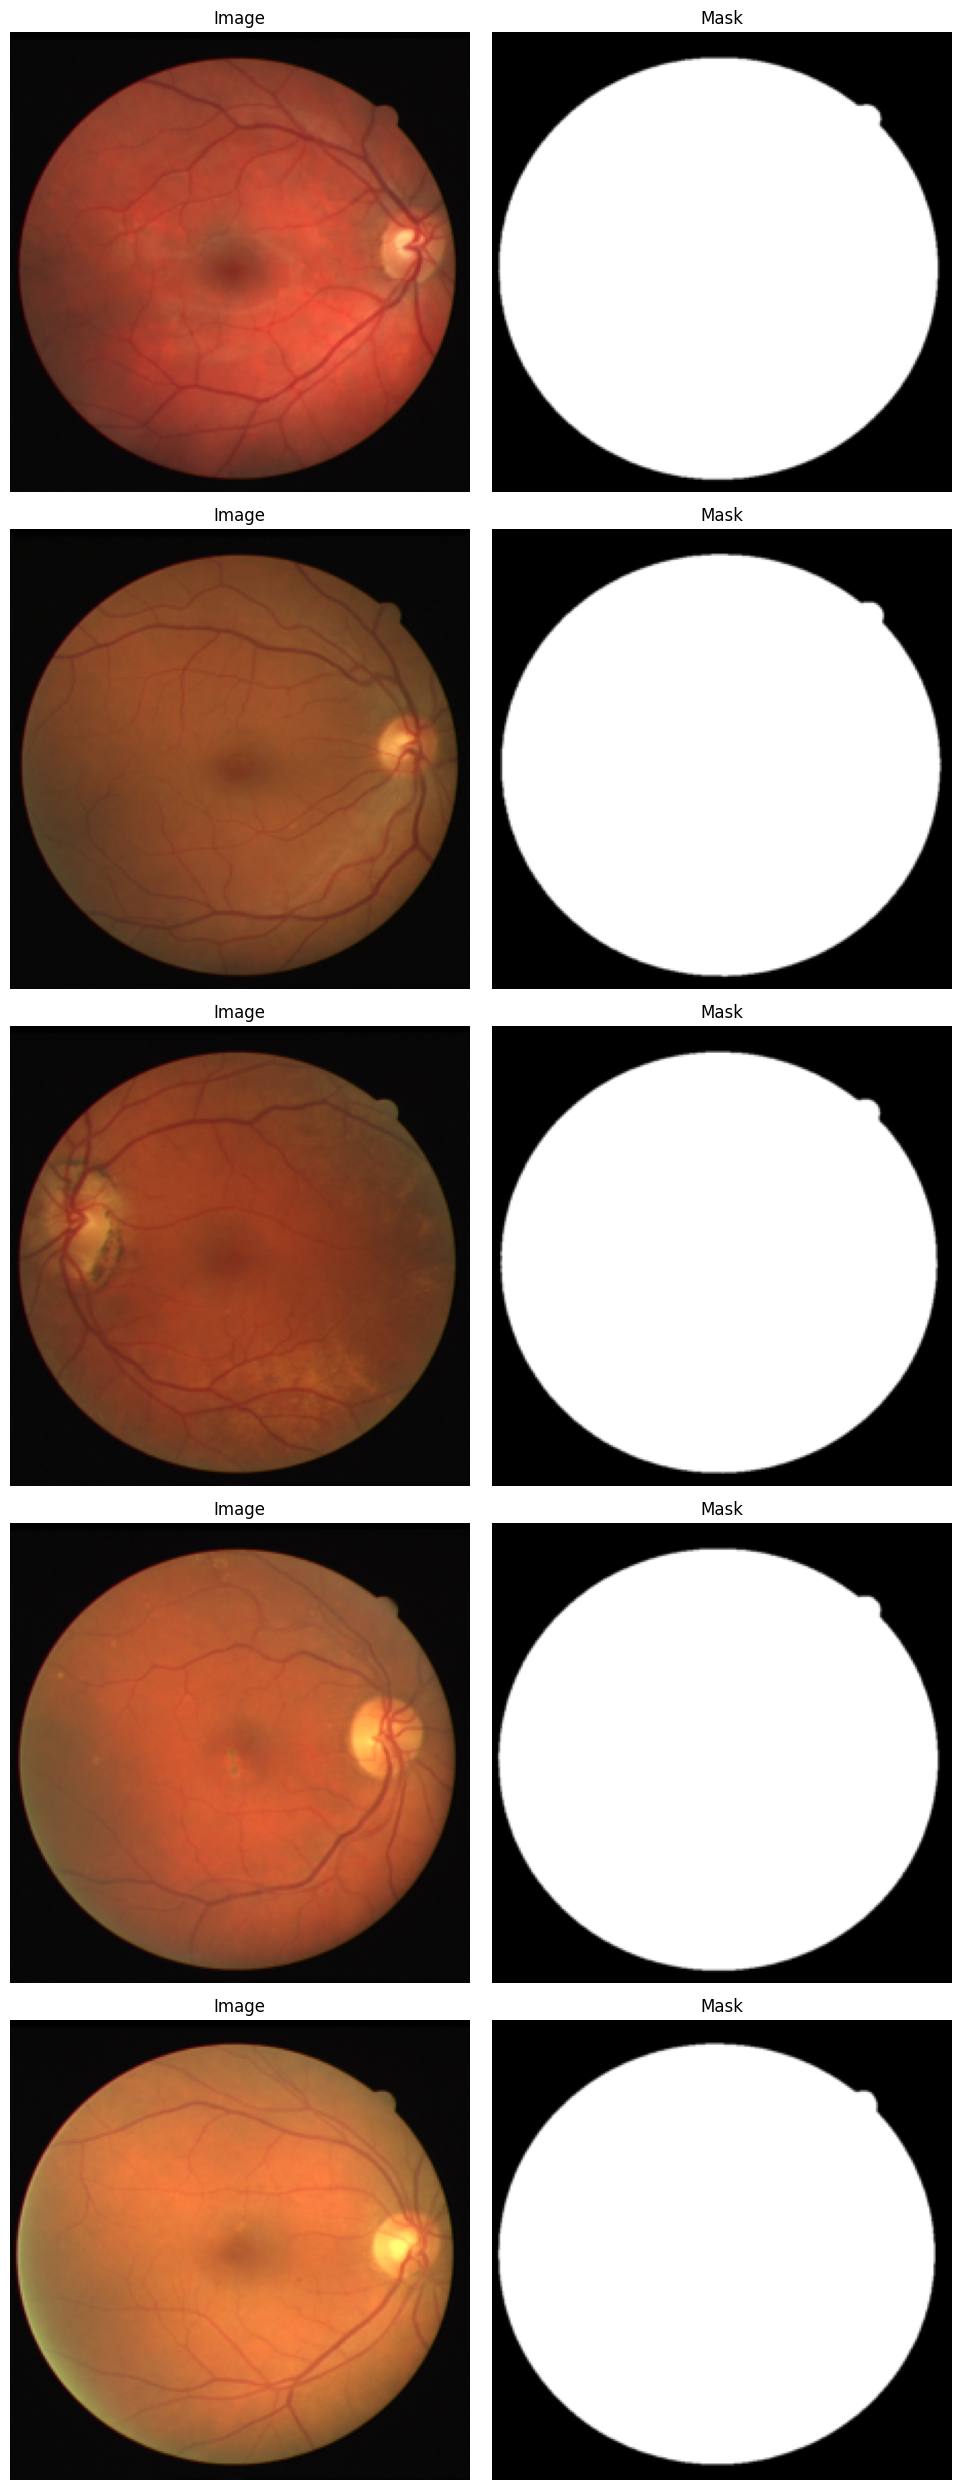

In [38]:
import matplotlib.pyplot as plt

def show_sample_images(data_loader, num_samples=5):
    # Get a batch of images and masks
    images, masks = next(iter(data_loader))

    # Convert tensors to numpy arrays and change shape for display
    images = images.numpy().transpose((0, 2, 3, 1))  # (batch_size, height, width, channels)

    # Prepare masks; squeeze the singleton dimension
    masks = masks.numpy()  # Masks are already single-channel
    masks = masks.squeeze()  # Remove the singleton dimension

    # Set up the figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        # Display the image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        # Display the mask
        if masks[i] is not None:
            axes[i, 1].imshow(masks[i], cmap='gray')
            axes[i, 1].set_title("Mask")
            axes[i, 1].axis("off")
        else:
            axes[i, 1].set_title("Mask not available")
            axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display samples from the training set
show_sample_images(train_loader, num_samples=5)


In [39]:
import cv2
import numpy as np
from PIL import Image

class ConvertColorAndApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert from PIL to numpy array
        img = np.array(img)

        # Convert RGB to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # Apply CLAHE on the V (value) channel of the HSV image
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        hsv_img[:, :, 2] = clahe.apply(hsv_img[:, :, 2])  # Apply CLAHE to V channel

        # Convert back to RGB after processing
        img_clahe = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

        # Convert back to PIL image
        return Image.fromarray(img_clahe)


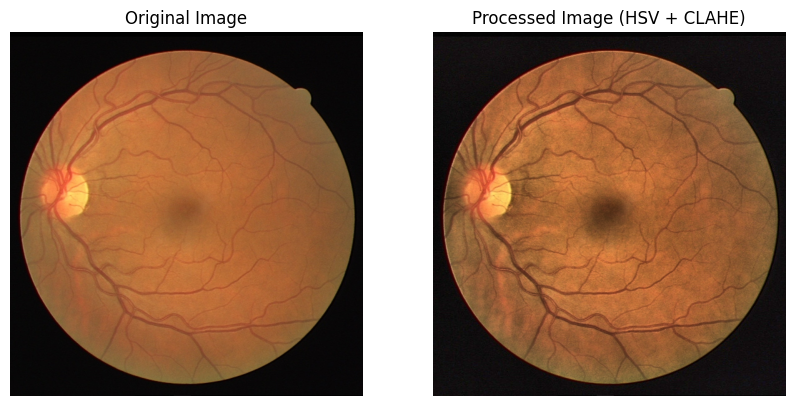

In [40]:
import matplotlib.pyplot as plt

# Load an image (example)
image_path = '/content/drive/MyDrive/p1/DRIVE/test/images/01_test.png'  # Path to an example image
original_img = Image.open(image_path)

# Initialize the CLAHE preprocessing class
preprocess = ConvertColorAndApplyCLAHE()

# Apply preprocessing
processed_img = preprocess(original_img)

# Visualize the original and processed images side by side
def visualize_images(original, processed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Processed Image
    axs[1].imshow(processed)
    axs[1].set_title("Processed Image (HSV + CLAHE)")
    axs[1].axis('off')

    plt.show()

# Call the visualization function
visualize_images(original_img, processed_img)

# Optionally, save the processed image to disk
processed_img.save('processed_image_clahe.png')


In [41]:
!pip install scikit-image numpy
!pip install scikit-learn



```
**Image segmentation**



In [42]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Check if GPU is available and use it if possible, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# UNet model as defined earlier
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Downsample to 112x112
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Downsample to 56x56
        )

        # Decoder: Adjusted to match 224x224 output size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),  # Upsample to 112x112
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2, padding=0),  # Upsample to 224x224
            nn.Conv2d(1, 1, kernel_size=1)  # Final output layer
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        output = self.decoder(x2)
        return output

# Define the loss function (binary cross-entropy with logits)
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam)
def get_optimizer(model):
    return optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    total_loss = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        total_loss += epoch_loss
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation loop
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # Convert the model output to binary predictions
            preds = torch.sigmoid(outputs) > 0.5

            # Calculate the number of correct predictions
            correct += (preds == masks).sum().item()
            total += masks.numel()

    accuracy = correct / total
    avg_loss = running_loss / len(data_loader)
    return avg_loss, accuracy

# Prepare datasets and data loaders (as already defined)
# Assuming you already have train_loader and test_loader ready
# Dataset transforms and DataLoader creation are skipped for brevity

# Instantiate the model, loss function, and optimizer
model = UNet().to(device)
optimizer = get_optimizer(model)
num_epochs = 5

# Train the model
train_model(model, train_loader, optimizer, criterion, num_epochs)

# Evaluate the model on training and test sets
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/5, Loss: 0.7185
Epoch 2/5, Loss: 0.6869
Epoch 3/5, Loss: 0.5107
Epoch 4/5, Loss: 0.3375
Epoch 5/5, Loss: 0.2811
Training Loss: 0.2657, Training Accuracy: 93.82%
Test Loss: 0.2579, Test Accuracy: 93.29%


In [43]:
pip install tensorflow opencv-python efficientnet


In [44]:
!pip install efficientnet_pytorch # install the correct package

In [45]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetSegmentation, self).__init__()

        # Load pre-trained EfficientNet-B3
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')

        # Segmentation Head (Upsampling to input image size)
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(1536, 512, kernel_size=3, padding=1),  # 1536 is the output channels of EfficientNet-B3's last layer
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, kernel_size=1),  # Output number of classes (1 for binary segmentation)
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)  # Upsample back to original image size
        )

    def forward(self, x):
        # Pass through EfficientNet Backbone (only up to the last convolutional layer)
        features = self.backbone.extract_features(x)

        # Pass through Segmentation Head
        out = self.segmentation_head(features)

        return out


In [46]:
class EfficientNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetSegmentation, self).__init__()

        # Load pre-trained EfficientNet-B3
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')

        # Segmentation Head (Upsampling to input image size)
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(1536, 512, kernel_size=3, padding=1),  # 1536 is the output channels of EfficientNet-B3's last layer
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, kernel_size=1)  # Output number of classes (1 for binary segmentation)
        )

    def forward(self, x):
        # Pass through EfficientNet Backbone (only up to the last convolutional layer)
        features = self.backbone.extract_features(x)

        # Pass through Segmentation Head
        out = self.segmentation_head(features)

        # Dynamically upsample to match input size (224x224 in this case)
        out = nn.functional.interpolate(out, size=(224, 224), mode='bilinear', align_corners=True)

        return out


In [47]:
import torch.optim as optim
import torch.nn.functional as F

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetSegmentation().to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train_model(model, train_loader, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    print("Finished Training")

# Call the training function
train_model(model, train_loader, num_epochs=10)


Loaded pretrained weights for efficientnet-b3
Epoch [1/10], Loss: 0.6291007598241171
Epoch [2/10], Loss: 0.46102844675381977
Epoch [3/10], Loss: 0.3994327982266744
Epoch [4/10], Loss: 0.3331203858057658
Epoch [5/10], Loss: 0.2672881583372752
Epoch [6/10], Loss: 0.2077340930700302
Epoch [7/10], Loss: 0.1506525625785192
Epoch [8/10], Loss: 0.1228182390332222
Epoch [9/10], Loss: 0.09035058567921321
Epoch [10/10], Loss: 0.07403595993916194
Finished Training


In [48]:
from sklearn.metrics import jaccard_score

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    jaccard_index = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Threshold the outputs to binary (0 or 1) for segmentation at 0.5
            predicted_masks = (outputs > 0.5).float()

            # Flatten tensors and convert to integers to calculate Jaccard Index (IoU)
            predicted_masks = predicted_masks.cpu().numpy().astype(int).flatten()
            true_masks = masks.cpu().numpy().astype(int).flatten()

            # Calculate the Jaccard score for each batch
            jaccard = jaccard_score(true_masks, predicted_masks, average='binary')
            jaccard_index.append(jaccard)

    avg_test_loss = test_loss / len(test_loader)
    avg_jaccard = sum(jaccard_index) / len(jaccard_index)

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Average Jaccard Index: {avg_jaccard:.4f}")

# Call the evaluation function
evaluate_model(model, test_loader)


Test Loss: 0.2198
Average Jaccard Index: 0.8875


In [49]:
# Save the trained model
torch.save(model.state_dict(), 'efficientnet_retinal_segmentation.pth')

# To load the model later
model.load_state_dict(torch.load('efficientnet_retinal_segmentation.pth'))


<ipython-input-49-ba87e1c27c41>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_retinal_segmentation.pth'))


<All keys matched successfully>

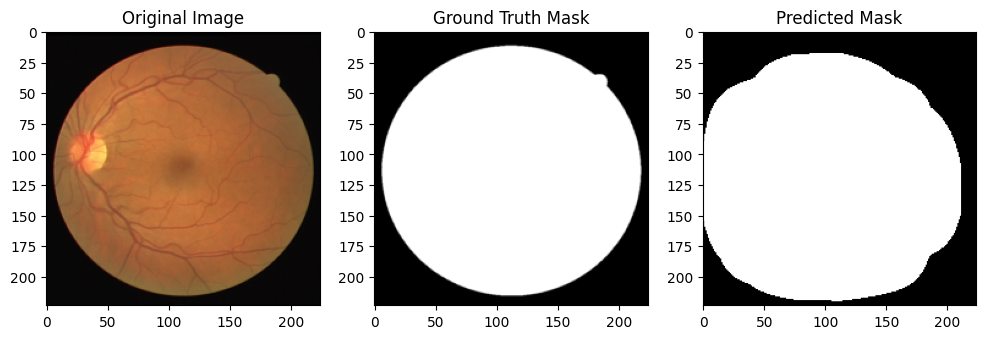

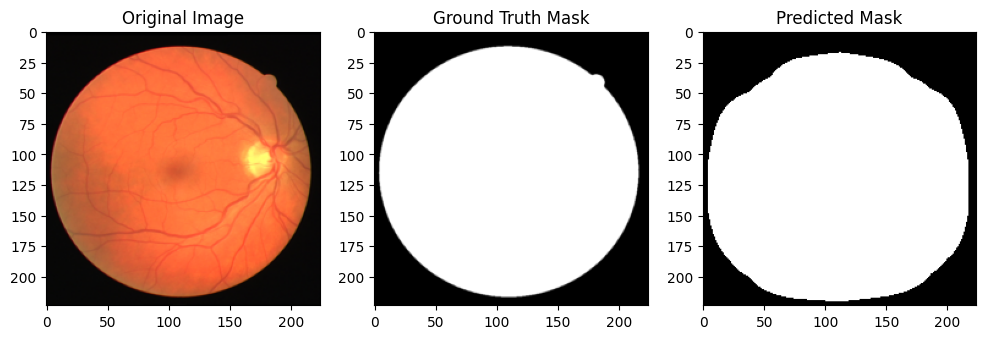

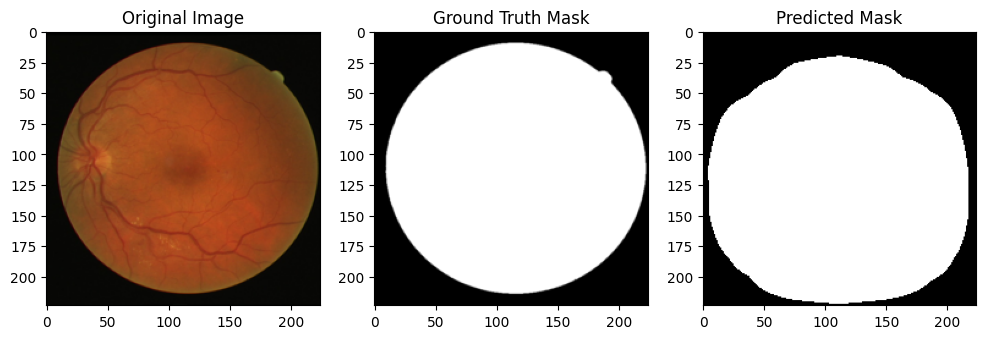

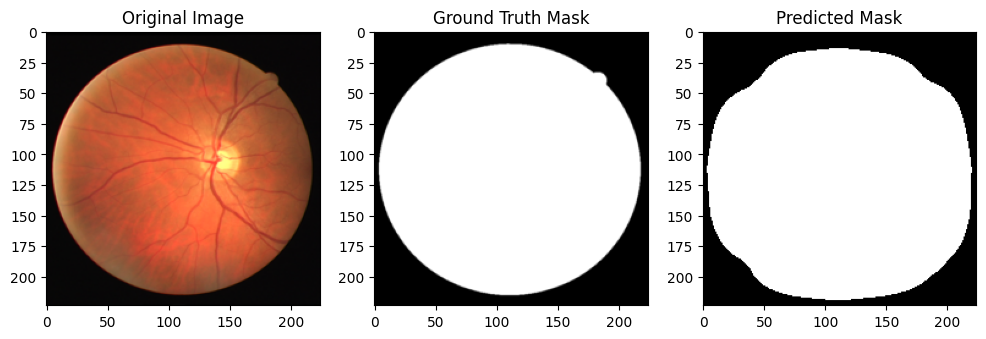

In [50]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader):
    model.eval()

    # Get a batch of test images and masks
    images, masks = next(iter(test_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        predicted_masks = (outputs > 0).float().cpu()  # Threshold the output

    # Plot images, ground truth masks, and predicted masks
    for i in range(min(4, len(images))):  # Show up to 4 images
        plt.figure(figsize=(12, 6))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert from Tensor to image format
        plt.title("Original Image")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")

        plt.show()

# Call the visualization function
visualize_predictions(model, test_loader)


In [51]:
from sklearn.metrics import accuracy_score, jaccard_score

def evaluate_model(model, data_loader, dataset_type="Test"):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    jaccard_index = []
    accuracy_list = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # Threshold the outputs to binary (0 or 1) for segmentation at 0.5
            predicted_masks = (outputs > 0.5).float()

            # Flatten tensors and convert to integers to calculate metrics
            predicted_masks = predicted_masks.cpu().numpy().astype(int).flatten()
            true_masks = masks.cpu().numpy().astype(int).flatten()

            # Calculate the Jaccard score (IoU) and accuracy for each batch
            jaccard = jaccard_score(true_masks, predicted_masks, average='binary')
            accuracy = accuracy_score(true_masks, predicted_masks)

            jaccard_index.append(jaccard)
            accuracy_list.append(accuracy)

    avg_loss = total_loss / len(data_loader)
    avg_jaccard = sum(jaccard_index) / len(jaccard_index)
    avg_accuracy = sum(accuracy_list) / len(accuracy_list)

    print(f"{dataset_type} Loss: {avg_loss:.4f}")
    print(f"{dataset_type} Jaccard Index (IoU): {avg_jaccard:.4f}")
    print(f"{dataset_type} Accuracy: {avg_accuracy:.4f}")

# Evaluate the model on the training set
print("Evaluating on the training set:")
evaluate_model(model, train_loader, dataset_type="Training")

# Evaluate the model on the test set
print("\nEvaluating on the test set:")
evaluate_model(model, test_loader, dataset_type="Test")


Evaluating on the training set:
Training Loss: 0.2013
Training Jaccard Index (IoU): 0.8944
Training Accuracy: 0.9239

Evaluating on the test set:
Test Loss: 0.2198
Test Jaccard Index (IoU): 0.8875
Test Accuracy: 0.9186
